#### Procrustes analysis 
Aims to align 2 sets of points (in other words, 2 shapes) to minimize square distance between them by removing scale, translation and rotation warp components.

In [32]:
def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2
        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)
    #rot =1
    #scale=2
    #translate=3
    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [33]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import cv2
import imageio
import scipy.ndimage as ndi

In [34]:
ct = cv2.imread('jpg/IMG-0004-00001.jpg', 0)

#### Masking

In [35]:
# mask2 = ct>30
# ct_mask = np.where(mask2, ct, 0)

# plt.imshow(ct_mask, cmap='gray')
# plt.axis('off')
# plt.show()

#### Translation
Shifting wrt center of mass

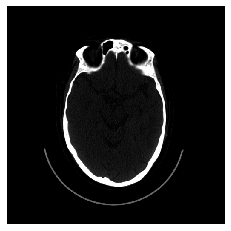

In [36]:
com = ndi.center_of_mass(ct)

d0 = 256 - com[0]
d1 = 256 - com[1]
ct = ndi.shift(ct, shift=[d0, d1])
plt.imshow(ct, cmap='gray')
plt.axis('off')
plt.show()

Save CT Image after pre-processing

In [37]:
# cv2.imwrite("jpg/ct_processed.jpg", ct) 

In [38]:
ct_points=[]
mri_points=[]

Specify the number of points

In [39]:
n=int(input())

5


In [40]:
# Define Click Function
def click_event_ct(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        ct_points.append([x,y])

In [41]:
# ct_fixed = cv2.imread('jpg/ct_processed.jpg',0)

cv2.imshow('Image CT', ct)

cv2.setMouseCallback('Image CT', click_event_ct)

# while True:
#     if(len(ct_points)<n):
#         continue
#     else:
#         cv2.waitKey(1)
#         cv2.destroyAllWindows()

cv2.waitKey(0)#press any key to close all windows
cv2.destroyAllWindows()

ct_points

256 79
133 253
253 253
374 257
254 427


[[256, 79], [133, 253], [253, 253], [374, 257], [254, 427]]

In [42]:
# Define Click Function
def click_event_mri(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,y)
        mri_points.append([x,y])

In [43]:
mri_registered = cv2.imread('jpg/IMG-0003-00001.jpg',0)

cv2.imshow('Image MRI', mri_registered)

cv2.setMouseCallback('Image MRI', click_event_mri)

# while True:
#     if(len(ct_points)<n):
#         continue
#     else:
#         cv2.waitKey(1)
#         cv2.destroyAllWindows()

cv2.waitKey(0)#press any key to close all windows
cv2.destroyAllWindows()

mri_points

121 16
43 126
129 126
208 122
128 245


[[121, 16], [43, 126], [129, 126], [208, 122], [128, 245]]

#### Specifying the co-ordinates

In [52]:
X_pts = np.asarray(ct_points)
Y_pts = np.asarray(mri_points)
print(X_pts)

[[256  79]
 [133 253]
 [253 253]
 [374 257]
 [254 427]]


In [45]:
d,Z_pts,Tform = procrustes(X_pts,Y_pts)

In [46]:
R = np.eye(3)

In [47]:
Tform

{'rotation': array([[ 0.99929247,  0.03761073],
        [-0.03761073,  0.99929247]]),
 'scale': 1.4963446163591947,
 'translation': array([73.04041801, 56.81884036])}

In [48]:
R[0:2,0:2] = Tform['rotation']

In [49]:
S = np.eye(3) * Tform['scale'] 
S[2,2] = 1
t = np.eye(3)
t[0:2,2] = Tform['translation']
M = np.dot(np.dot(R,S),t.T).T
tr_Y_img = cv2.warpAffine(mri_registered,M[0:2,:],(500,500))
cv2.imwrite("jpg/mri_registered.jpg", tr_Y_img) 

True

In [50]:
aY_pts = np.hstack((Y_pts,np.array(([[1,1,1,1,1]])).T))
tr_Y_pts = np.dot(M,aY_pts.T).T

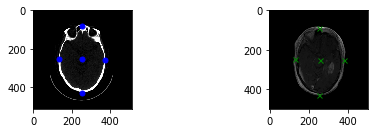

In [51]:
plt.figure() 
plt.subplot(1,3,1)
plt.imshow(ct,cmap=cm.gray)
plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5)
# plt.axis('off')
# plt.subplot(1,3,2)
# plt.imshow(mri_registered,cmap=cm.gray)
# plt.plot(Y_pts[:,0],Y_pts[:,1],'ro',markersize=5)
# plt.axis('off')
plt.subplot(1,3,3)
# plt.imshow(ct_fixed,cmap=cm.gray)
plt.imshow(tr_Y_img,cmap=cm.gray)
# plt.plot(X_pts[:,0],X_pts[:,1],'bo',markersize=5) 
# plt.plot(Z_pts[:,0],Z_pts[:,1],'ro',markersize=5)
plt.plot(tr_Y_pts[:,0],tr_Y_pts[:,1],'gx',markersize=5)
# plt.axis('off')
plt.show()